In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_fwf(
    "./data/auto-mpg.data",
    names=["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year", "origin", "car_name"]
)

In [ ]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,"""chevrolet chevelle malibu"""
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,"""buick skylark 320"""
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,"""plymouth satellite"""
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,"""amc rebel sst"""
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,"""ford torino"""


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [5]:
df.describe()

,mpg,cylinders,displacement,weight,acceleration,model_year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


In [6]:
df.describe(include="O")

,horsepower,car_name
count,398,398
unique,94,305
top,150.0,"""ford pinto"""
freq,22,6


In [7]:
df[df["horsepower"].str.contains(r"[^0-9.]", regex=True)]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
32,25.0,4,98.0,?,2046.0,19.0,71,1,"""ford pinto"""
126,21.0,6,200.0,?,2875.0,17.0,74,1,"""ford maverick"""
330,40.9,4,85.0,?,1835.0,17.3,80,2,"""renault lecar deluxe"""
336,23.6,4,140.0,?,2905.0,14.3,80,1,"""ford mustang cobra"""
354,34.5,4,100.0,?,2320.0,15.8,81,2,"""renault 18i"""
374,23.0,4,151.0,?,3035.0,20.5,82,1,"""amc concord dl"""


In [10]:
df[df["car_name"] == "\"ford pinto\""]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
32,25.0,4,98.0,?,2046.0,19.0,71,1,"""ford pinto"""
112,19.0,4,122.0,85.00,2310.0,18.5,73,1,"""ford pinto"""
130,26.0,4,122.0,80.00,2451.0,16.5,74,1,"""ford pinto"""
168,23.0,4,140.0,83.00,2639.0,17.0,75,1,"""ford pinto"""
174,18.0,6,171.0,97.00,2984.0,14.5,75,1,"""ford pinto"""
206,26.5,4,140.0,72.00,2565.0,13.6,76,1,"""ford pinto"""


In [14]:
cleaned_df = df.copy()

cleaned_df["horsepower"] = cleaned_df["horsepower"].replace("?", np.nan)
cleaned_df["horsepower"] = pd.to_numeric(cleaned_df["horsepower"], errors="coerce")

cleaned_df["car_name"] = cleaned_df["car_name"].str.replace("\"", "")

cleaned_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


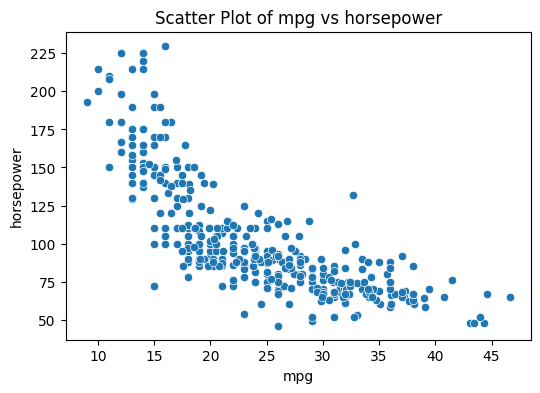

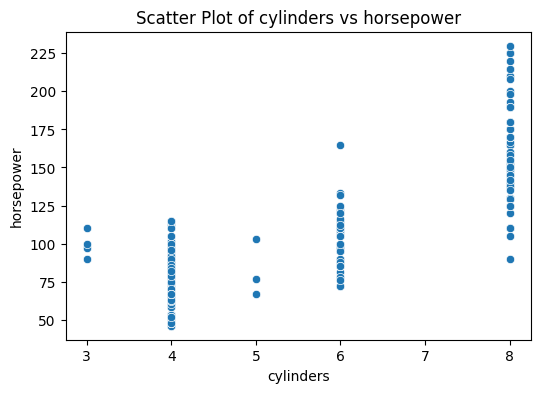

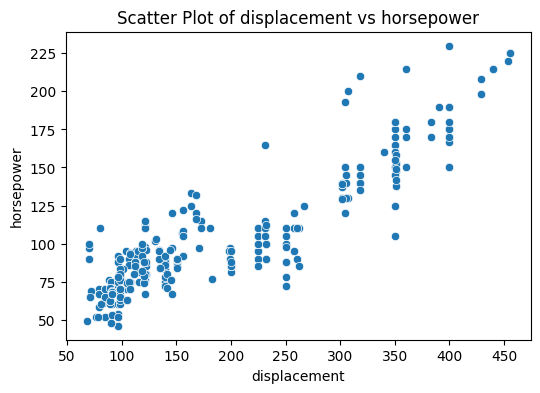

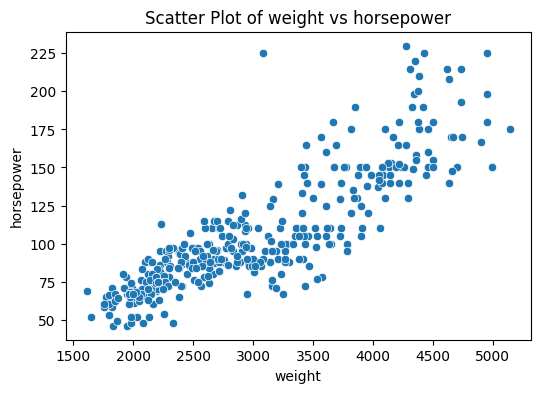

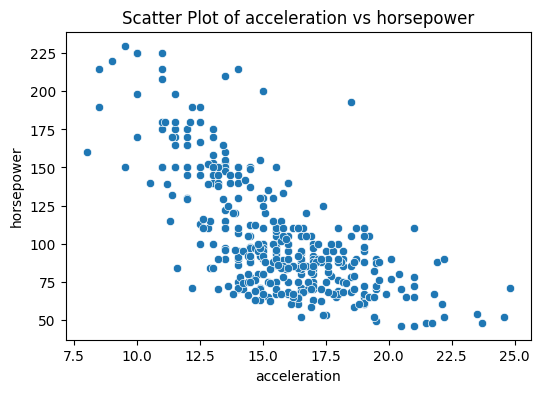

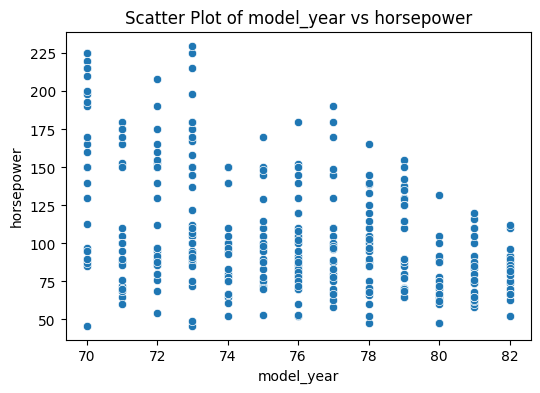

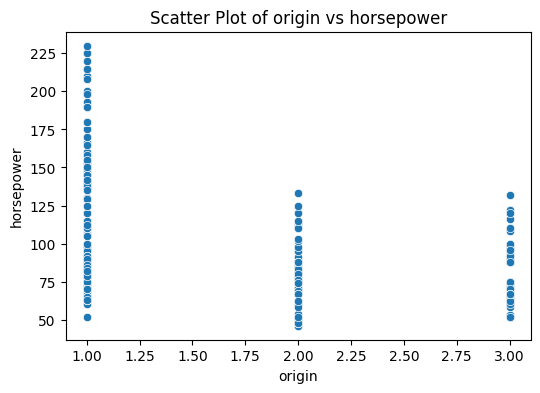

In [15]:
numeric_columns = cleaned_df.select_dtypes(include=["number"]).columns

for col in numeric_columns:
    if col != "horsepower":
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=cleaned_df[col], y=cleaned_df["horsepower"])
        plt.xlabel(col)
        plt.ylabel("horsepower")
        plt.title(f"Scatter Plot of {col} vs horsepower")
        plt.show()

## Simple Linear Regression

Let's try an inference question, for example I want to know how mpg affects horsepower of a vehicle

In [16]:
x_vars = cleaned_df[["mpg"]]
y_var = cleaned_df["horsepower"]

x_vars = sm.add_constant(x_vars)

model = sm.OLS(y_var, x_vars, missing="drop", hasconst=True).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             horsepower   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Tue, 18 Mar 2025   Prob (F-statistic):           7.03e-81
Time:                        13:28:27   Log-Likelihood:                -1804.2
No. Observations:                 392   AIC:                             3612.
Df Residuals:                     390   BIC:                             3620.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        194.4756      3.873     50.211      0.0

### p, t and F Statistics

The $p, t$ and $F$ stats come from hypothesis tests on our model, where:

* $H_0: \beta_m = 0$ : The null hypothesis that the variable associated with coefficient $\beta_m$ has no relationship with the target variable.
* $H_1: \beta_m \ne 0$ : The alternative hypothesis that the variable associated with coefficient $\beta_m$ has a relationship with the target variable.

Given this hypothesis test, the $p$ and $t$ statistics are loosely defined as:
* $t$ - the number of standard deviations $\beta_m$ is away from 0
* $p$ - the probability of getting our results under/assuming the null hypothesis

The $F$ statistic is more applicable to the multiple linear regression case because the test associated with it is whether all the coefficients are zero (null hypothesis) or at least one is non-zero (alternative hypothesis).

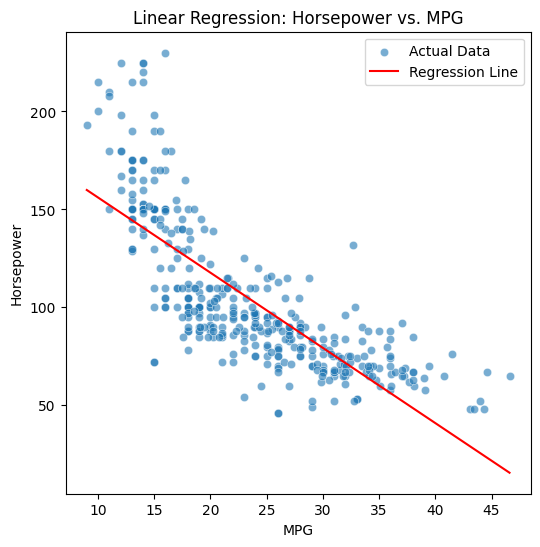

In [17]:
plt.figure(figsize=(6, 6))

sns.scatterplot(x=cleaned_df["mpg"], y=cleaned_df["horsepower"], label="Actual Data", alpha=0.6)

x_vals = np.linspace(cleaned_df["mpg"].min(), cleaned_df["mpg"].max(), 100)
x_vals_const = sm.add_constant(x_vals)
y_preds = model.predict(x_vals_const)

plt.plot(x_vals, y_preds, color="red", label="Regression Line")

plt.xlabel("MPG")
plt.ylabel("Horsepower")
plt.title("Linear Regression: Horsepower vs. MPG")
plt.legend()

In [18]:
single_var_resid = model.resid

single_var_resid

0       4.624341
1      28.107677
2      24.624341
3      16.946565
4      10.785453
         ...    
393    -4.825666
394    26.435430
395    12.368774
396    -7.986778
397     6.529886
Length: 392, dtype: float64

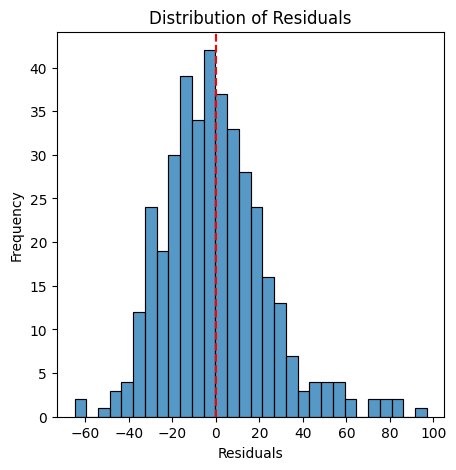

In [21]:
plt.figure(figsize=(5, 5))
sns.histplot(single_var_resid, bins=30)
plt.axvline(0, color="red", linestyle="dashed")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

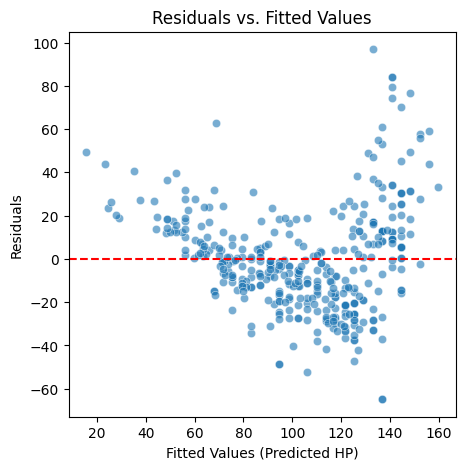

In [23]:
fitted_values = model.fittedvalues

plt.figure(figsize=(5, 5))
sns.scatterplot(x=fitted_values, y=single_var_resid, alpha=0.6)
plt.axhline(0, color="red", linestyle="dashed")
plt.xlabel("Fitted Values (Predicted HP)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.show()

### Feature Engineering Our Predictor

In [26]:
cleaned_df["mpg_sqrt"] = np.sqrt(cleaned_df["mpg"])

x_vars = cleaned_df[["mpg", "mpg_sqrt"]]
y_var = cleaned_df["horsepower"]

x_vars = sm.add_constant(x_vars)

model = sm.OLS(y_var, x_vars, missing="drop", hasconst=True).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             horsepower   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     533.8
Date:                Tue, 18 Mar 2025   Prob (F-statistic):          2.98e-112
Time:                        13:59:11   Log-Likelihood:                -1727.9
No. Observations:                 392   AIC:                             3462.
Df Residuals:                     389   BIC:                             3474.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        648.8238     33.558     19.335      0.0

# Multiple Linear Regression

In [27]:
x_vars = cleaned_df[["mpg", "mpg_sqrt", "weight", "cylinders", "displacement", "acceleration"]]
y_var = cleaned_df["horsepower"]

x_vars = sm.add_constant(x_vars)

multi_model = sm.OLS(y_var, x_vars, missing="drop", hasconst=True).fit()

print(multi_model.summary())

                            OLS Regression Results                            
Dep. Variable:             horsepower   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     573.9
Date:                Tue, 18 Mar 2025   Prob (F-statistic):          1.43e-188
Time:                        14:04:24   Log-Likelihood:                -1536.5
No. Observations:                 392   AIC:                             3087.
Df Residuals:                     385   BIC:                             3115.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          308.4773     32.400      9.521   

### Variance Inflation Factor

The VIF is the ratio of variance of $\beta_m$ when fitting the full model divided by the variance of $\beta_m$ on its own - i.e. how much does $\beta_m$ contribute to the variance?

$$
VIF(\beta_m) = \frac{1}{1 - R^2_{X_m|X_{-m}}}
$$

Rule of thumb is that a $VIF > 10$ is a problematic amount of collinearity.

In [28]:
vif_data = pd.DataFrame()
vif_data["Variable"] = x_vars.columns
vif_data["VIF"] = [variance_inflation_factor(x_vars.values, i) for i in range(x_vars.shape[1])]

vif_data

,Variable,VIF
0,const,2735.346730
1,mpg,175.626921
2,mpg_sqrt,207.201623
3,weight,10.438861
4,cylinders,10.628668
5,displacement,18.489746
6,acceleration,1.571167


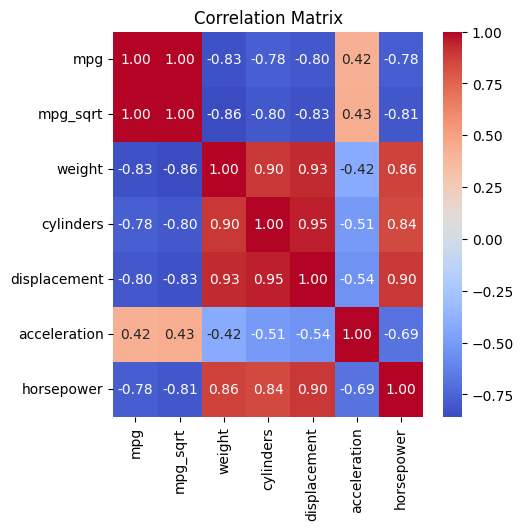

In [29]:
corr_matrix = cleaned_df[["mpg", "mpg_sqrt", "weight", "cylinders", "displacement", "acceleration", "horsepower"]].corr()

plt.figure(figsize=(5,5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [30]:
x_vars = cleaned_df[["mpg_sqrt", "acceleration", "cylinders"]]
y_var = cleaned_df["horsepower"]

x_vars = sm.add_constant(x_vars)

multi_transform_model = sm.OLS(y_var, x_vars, missing="drop", hasconst=True).fit()

print(multi_transform_model.summary())

                            OLS Regression Results                            
Dep. Variable:             horsepower   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     695.1
Date:                Tue, 18 Mar 2025   Prob (F-statistic):          1.26e-155
Time:                        14:15:08   Log-Likelihood:                -1623.6
No. Observations:                 392   AIC:                             3255.
Df Residuals:                     388   BIC:                             3271.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          205.4457     12.871     15.962   

In [31]:
vif_data = pd.DataFrame()
vif_data["Variable"] = x_vars.columns
vif_data["VIF"] = [variance_inflation_factor(x_vars.values, i) for i in range(x_vars.shape[1])]

vif_data

,Variable,VIF
0,const,277.073968
1,mpg_sqrt,2.843875
2,acceleration,1.347062
3,cylinders,3.098598


### Adding Interactions

In [32]:
cleaned_df["cyl_x_disp"] = cleaned_df["cylinders"] * cleaned_df["displacement"]

In [33]:
x_vars = cleaned_df[["mpg_sqrt", "acceleration","cyl_x_disp"]]
y_var = cleaned_df["horsepower"]

x_vars = sm.add_constant(x_vars)

multi_model_with_transforms = sm.OLS(y_var, x_vars, missing="drop", hasconst=True).fit()

print(multi_model_with_transforms.summary())

                            OLS Regression Results                            
Dep. Variable:             horsepower   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     972.4
Date:                Tue, 18 Mar 2025   Prob (F-statistic):          4.78e-180
Time:                        14:20:18   Log-Likelihood:                -1566.8
No. Observations:                 392   AIC:                             3142.
Df Residuals:                     388   BIC:                             3158.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          188.0461      9.789     19.210   

In [34]:
vif_data = pd.DataFrame()
vif_data["Variable"] = x_vars.columns
vif_data["VIF"] = [variance_inflation_factor(x_vars.values, i) for i in range(x_vars.shape[1])]

vif_data

,Variable,VIF
0,const,214.548484
1,mpg_sqrt,2.970648
2,acceleration,1.465966
3,cyl_x_disp,3.524536


## Predictive Modelling

In [35]:
without_unknowns_df = cleaned_df.dropna().copy()
with_unknowns_df = cleaned_df[cleaned_df["horsepower"].isna()].copy()

In [39]:
X = without_unknowns_df.drop(["horsepower", "car_name"], axis=1)
y = without_unknowns_df["horsepower"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
features = ["mpg_sqrt", "acceleration", "cyl_x_disp", "cylinders", "displacement"]

In [44]:
X_train_features = X_train[features]
lm = LinearRegression()
lm.fit(X_train_features, y_train)

print("Intercept: ", lm.intercept_)
print("Coefficients: ", lm.coef_)

Intercept:  241.52272274199848
Coefficients:  [-13.64456577  -3.39756953   0.0515646  -10.11740759  -0.13920872]


In [45]:
y_train_pred = lm.predict(X_train_features)
train_r2 = lm.score(X_train_features, y_train)
train_rmse = root_mean_squared_error(y_train, y_train_pred)

print(f"Train R2: {train_r2}")
print(f"Train RMSE: {train_rmse}")

Train R2: 0.8943808133361387
Train RMSE: 12.421959024805194


In [46]:
X_test_features = X_test[features]
y_pred = lm.predict(X_test_features)

rmse = root_mean_squared_error(y_test, y_pred)
r2_test = lm.score(X_test_features, y_test)

print(f"Test Set R^2: {r2_test}")
print(f"Test RMSE: {rmse}")

Test Set R^2: 0.8940043955956463
Test RMSE: 12.793589382830337


In [ ]:
lm = LinearRegression()

lm.fit(X[features], y)

print("Intercept: ", lm.intercept_)
print("Coefficients: ", lm.coef_)

Intercept:  236.49227261773737
Coefficients:  [-13.05592496  -3.35357571   0.05040782 -10.42954847  -0.11649005]


In [54]:
predict_unknowns = lm.predict(with_unknowns_df[features])

predict_unknowns

array([74.12035502, 94.26580142, 60.497525  , 95.31225383, 73.61550896,
       76.26808444])

In [55]:
with_unknowns_df["predicted_horsepower"] = predict_unknowns

with_unknowns_df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,mpg_sqrt,cyl_x_disp,predicted_horsepower
32,25.0,4,98.0,NaN,2046.0,19.0,71,1,ford pinto,5.000000,392.0,74.120355
126,21.0,6,200.0,NaN,2875.0,17.0,74,1,ford maverick,4.582576,1200.0,94.265801
330,40.9,4,85.0,NaN,1835.0,17.3,80,2,renault lecar deluxe,6.395311,340.0,60.497525
336,23.6,4,140.0,NaN,2905.0,14.3,80,1,ford mustang cobra,4.857983,560.0,95.312254
354,34.5,4,100.0,NaN,2320.0,15.8,81,2,renault 18i,5.873670,400.0,73.615509
374,23.0,4,151.0,NaN,3035.0,20.5,82,1,amc concord dl,4.795832,604.0,76.268084


## Experimentation

In [56]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func=f_regression, k=5)
X_new = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)

Selected Features: Index(['cylinders', 'displacement', 'weight', 'mpg_sqrt', 'cyl_x_disp'], dtype='object')


In [57]:
feature_sets = {
    "Baseline": ["mpg_sqrt", "acceleration"],
    "Our Selected Features": ["mpg_sqrt", "acceleration", "cylinders", "displacement","cyl_x_disp"],
    "KBest": ['cylinders', 'displacement', 'weight', 'mpg_sqrt', 'cyl_x_disp']
}

results = {}

for name, features in feature_sets.items():
    X_train_subset = X_train[features]
    X_test_subset = X_test[features]
    
    model = LinearRegression()
    model.fit(X_train_subset, y_train)
    
    y_pred = model.predict(X_test_subset)
    rmse = root_mean_squared_error(y_test, y_pred)
    
    results[name] = rmse

for model_name, rmse in results.items():
    print(f"{model_name}: RMSE = {rmse}")

Baseline: RMSE = 18.874595800757263
Our Selected Features: RMSE = 12.793589382830362
KBest: RMSE = 13.92075749308832
